In [23]:
cd ..

C:\Users\688228hh


In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm, lognorm, ncx2
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.Heston import *
from scipy.optimize import minimize
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

In [3]:
df = pd.read_parquet(r"data/oxford_data.parquet")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.loc[df['Symbol']=='.SPX'].reset_index(drop=True)
df['Time'] = pd.to_datetime(df['Time'], utc=True) 
df['Time'] = df['Time'].dt.date
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)
df = df.loc[pd.to_datetime('2014-01-01'):pd.to_datetime('2018-06-01')]
df['return'] = np.log(df['close_price']).diff()

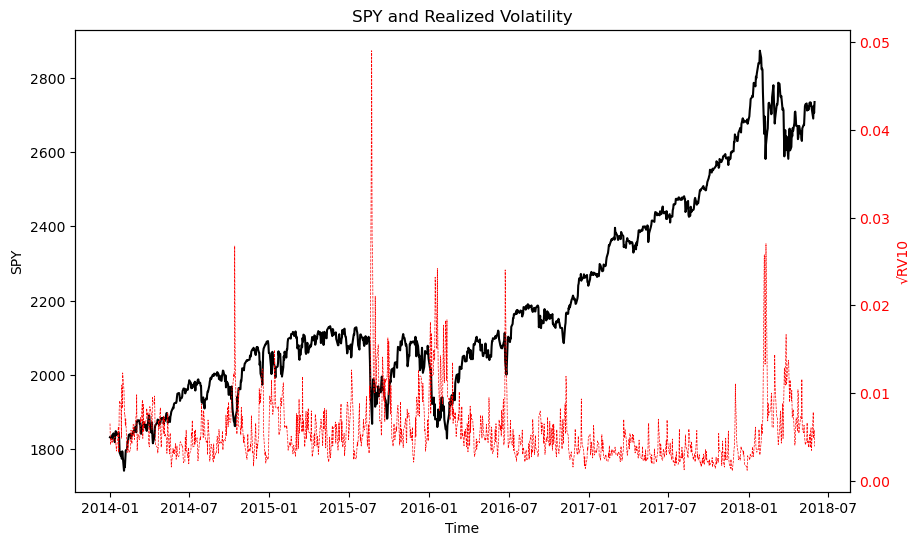

In [4]:
# Assuming df is your DataFrame and already has datetime index
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot close price on the left y-axis
color = 'black'
ax1.set_xlabel('Time')
ax1.set_ylabel('SPY', color=color)
ax1.plot(df.index, df['close_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for RV
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('√RV10', color=color)
ax2.plot(df.index, np.sqrt(df['rv10']), color=color, linestyle='dashed', linewidth=0.5)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.title('SPY and Realized Volatility')
plt.show()

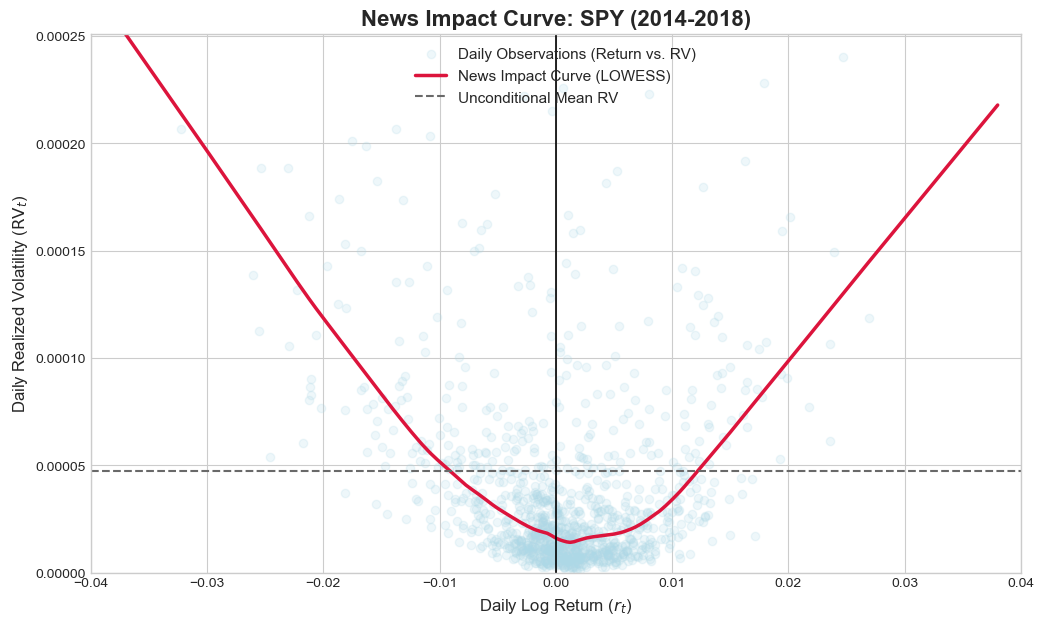

In [5]:
df['next_day_rv10'] = df['rv10'].shift(-1)

df_nic = df.dropna()

# Define our x (independent) and y (dependent) variables
x_returns = df_nic['return']
y_next_vol = df_nic['rv10']

# --- 3. Perform LOWESS Smoothing ---
# LOWESS fits a smooth curve to the data non-parametrically.
# The 'frac' parameter controls the amount of smoothing (0.3 is a good start).
lowess_fit = sm.nonparametric.lowess(endog=y_next_vol, exog=x_returns, frac=0.3)

# Extract the smoothed x and y values
x_smooth = lowess_fit[:, 0]
y_smooth = lowess_fit[:, 1]

# --- 4. Generate the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the raw observations as a scatter plot
ax.scatter(x_returns, y_next_vol, alpha=0.2, color='lightblue', label='Daily Observations (Return vs. RV)')

# Plot the smoothed News Impact Curve
ax.plot(x_smooth, y_smooth, color='crimson', linewidth=2.5, label='News Impact Curve (LOWESS)')

# Add reference lines for clarity
ax.axhline(y=y_next_vol.mean(), color='dimgray', linestyle='--', linewidth=1.5, label=f'Unconditional Mean RV')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.2)

# Add titles and labels for a publication-quality figure
ax.set_title('News Impact Curve: SPY (2014-2018)', fontsize=16, weight='bold')
ax.set_xlabel('Daily Log Return ($r_t$)', fontsize=12)
ax.set_ylabel('Daily Realized Volatility ($\mathrm{RV}_t$)', fontsize=12)
ax.legend(loc='upper center', fontsize=11)

# Set axis limits to focus on the area of interest
ax.set_xlim(-0.04, 0.04)
ax.set_ylim(0, df_nic['next_day_rv10'].quantile(0.98)) # Zoom in by excluding extreme outliers

plt.show()


In [6]:
daily_returns = df['return'].iloc[1:]
daily_RV = df['rv10'].iloc[1:]

burnin = 252
dt = 1  # Daily

split_index = round(df.shape[0] * 0.82)

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

## QLKF-RV

In [7]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.02, 0.00015, 0.001, 0.001]) # kappa, theta, xi, sigma

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

C:\Users\688228hh\Kalman-Heston-Filter\src\KalmanFilterSV.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  innovation = y[t] - y_pred
C:\Users\688228hh\Kalman-Heston-Filter\src\KalmanFilterSV.py:375: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  innovation = y[t] - y_pred



QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.000013
theta: 0.454757
xi: 0.009197
sigma: 0.000001
Negative Log-Likelihood: -5638.767108
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [1.26720312e-05 4.54756597e-01 9.19716615e-03 1.00000000e-06]


## HAR-RV

In [8]:
def har_rv_forecast(train_RV, test_RV):
    train_RV = pd.Series(train_RV)
    test_RV = pd.Series(test_RV)
    
    lag1_tr = train_RV.shift(1)
    lag5_tr = train_RV.rolling(5).mean().shift(1)
    lag21_tr = train_RV.rolling(21).mean().shift(1)
    
    df_tr = pd.DataFrame({
        'y': train_RV,
        'x1': lag1_tr,
        'x5': lag5_tr,
        'x21': lag21_tr
    }).dropna()
    
    X_tr = sm.add_constant(df_tr[['x1', 'x5', 'x21']])
    model = sm.OLS(df_tr['y'], X_tr)
    results = model.fit()
    
    beta_const = results.params['const']
    beta_x1 = results.params['x1']
    beta_x5 = results.params['x5']
    beta_x21 = results.params['x21']
    
    full_RV = pd.concat([train_RV, test_RV])
    
    # Compute lags on the full series
    lag1_full = full_RV.shift(1)
    lag5_full = full_RV.rolling(5).mean().shift(1)
    lag21_full = full_RV.rolling(21).mean().shift(1)
    
    # Extract ONLY the test period features
    test_start_idx = len(train_RV)
    test_end_idx = len(full_RV)
    
    # Test set features
    x1_test = lag1_full.iloc[test_start_idx:test_end_idx]
    x5_test = lag5_full.iloc[test_start_idx:test_end_idx]
    x21_test = lag21_full.iloc[test_start_idx:test_end_idx]
    
    forecasts = beta_const + beta_x1 * x1_test + beta_x5 * x5_test + beta_x21 * x21_test
    
    # forecasts = forecasts.dropna()
    
    if len(forecasts) == 0:
        raise ValueError("All forecasts are NaN. Ensure training data has >21 periods and no missing values.")
    
    # Align with test_RV index
    forecast_index = test_RV.index[:len(forecasts)]
    forecasts = pd.Series(forecasts.values, index=forecast_index, name='HAR_RV_pred')
    
    # Get fitted values (in-sample fit) from training phase
    fitted_values = results.fittedvalues
    n_missing = len(train_RV) - len(fitted_values)
    if n_missing > 0:
        padding = pd.Series([0.0] * n_missing, index=train_RV.index[:n_missing])
        fitted_values = pd.concat([padding, fitted_values])
        fitted_values.name = 'HAR_RV_fitted'
    
    # Return parameters as a dictionary for clarity
    params_dict = {
        'const': beta_const,
        'x1': beta_x1,
        'x5': beta_x5, 
        'x21': beta_x21
    }
    
    return np.array(forecasts), np.array(fitted_values), params_dict, results

In [9]:
pred_HAR, fit_HAR, params_HAR, results_HAR = har_rv_forecast(train_RV, test_RV)

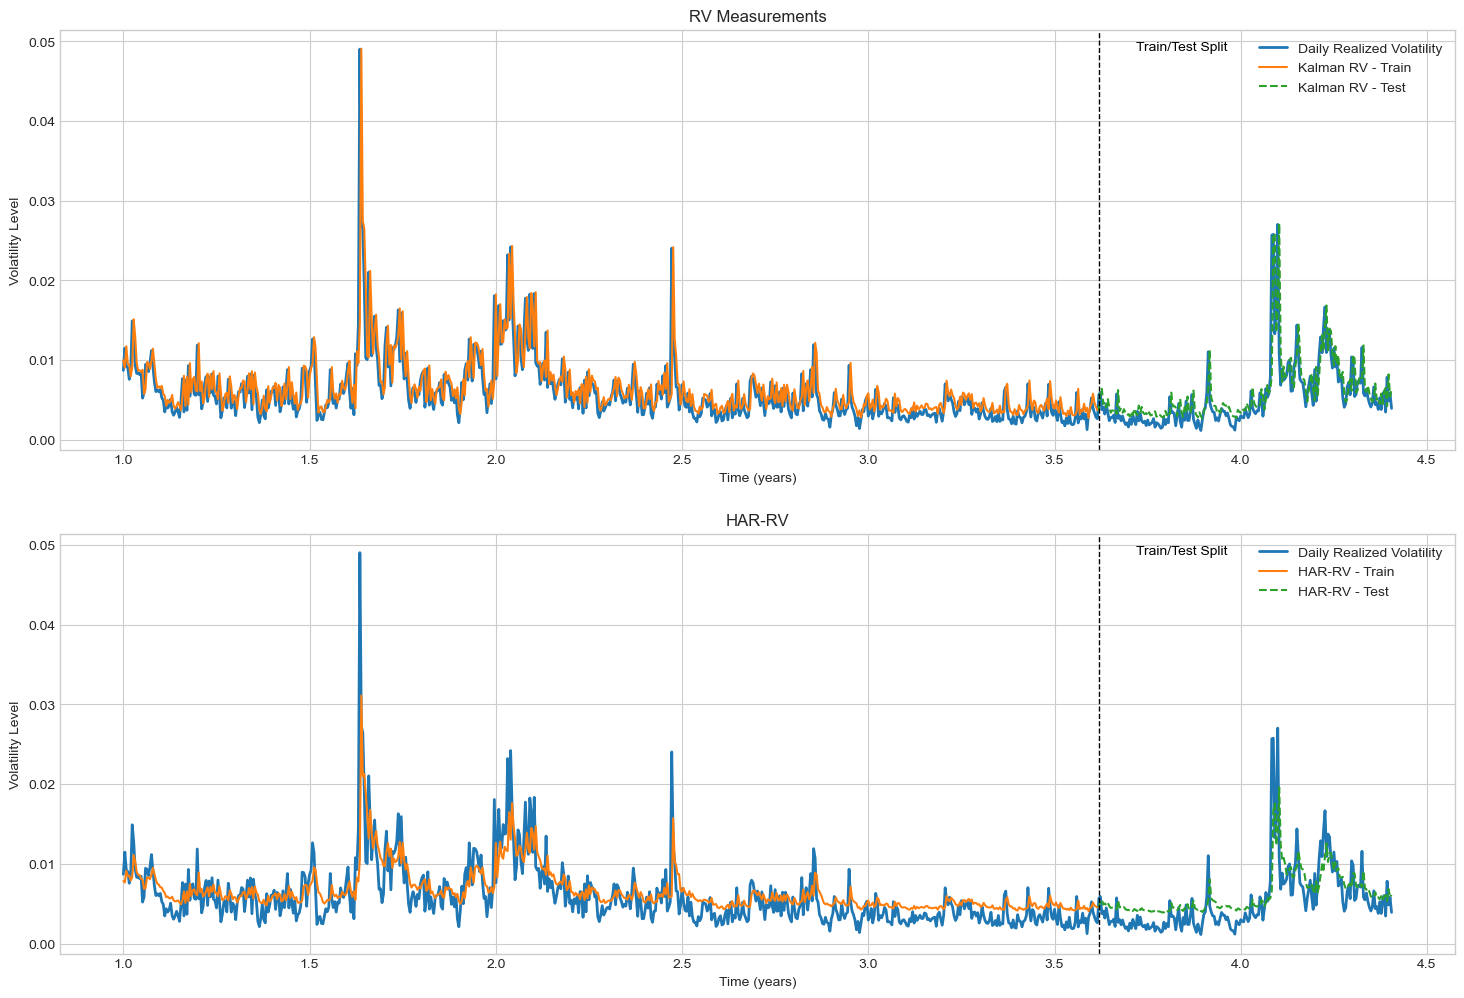

In [10]:
v_item = 'V_pred'

titles_all = ["RV Measurements", "HAR-RV"]
labels_all = ["Kalman RV", "HAR-RV"]
train_all = [train_result_rv[v_item], fit_HAR]
test_all = [test_result_rv[v_item], pred_HAR]

burnin = 252
time_daily = np.arange(len(daily_returns)) / 252
n_filters = len(train_all)
fig, axes = plt.subplots(n_filters, 1, figsize=(18, 6 * n_filters))

for i, ax in enumerate(axes):
    # Slice data
    filt_train = train_all[i][burnin:]
    true_train = daily_RV[burnin:split_index]
    filt_test = test_all[i]
    true_test = daily_RV[split_index:]

    # Sanity checks
    assert len(filt_train) == len(true_train), f"In-sample length mismatch for {titles_all[i]}"
    assert len(filt_test) == len(true_test), f"Out-of-sample length mismatch for {titles_all[i]}"

    # Plot true and predicted volatility
    ax.plot(time_daily[burnin:], np.sqrt(daily_RV[burnin:]), label="Daily Realized Volatility", lw=2)
    ax.plot(time_daily[burnin:split_index], np.sqrt(filt_train), label=f"{labels_all[i]} - Train", lw=1.5)
    ax.plot(time_daily[split_index:], np.sqrt(filt_test), label=f"{labels_all[i]} - Test", lw=1.5, linestyle="--")

    # Mark the train/test split
    ax.axvline(time_daily[split_index], color='black', linestyle='--', lw=1)
    ax.text(time_daily[split_index] + 0.1, ax.get_ylim()[1]*0.95, 'Train/Test Split', color='black')

    # === Add vertical lines for negative predicted variances ===
    # For train
    neg_train_indices = np.where(np.array(filt_train) < 0)[0]
    for idx in neg_train_indices:
        ax.axvline(time_daily[burnin + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # For test
    neg_test_indices = np.where(np.array(filt_test) < 0)[0]
    for idx in neg_test_indices:
        ax.axvline(time_daily[split_index + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # Final plot styling
    ax.set_title(f"{titles_all[i]}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Volatility Level")
    ax.legend(loc="upper right")
    ax.grid(True)

In [11]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    ratio = y / h
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'HAR-RV']
true_variances = daily_RV[split_index:]
true_volatilities = np.sqrt(true_variances)

rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all)):
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    pred_vol = np.sqrt(pred_var)

    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.002819, QLIKE: 0.291451
HAR-RV             RMSE: 0.002815, QLIKE: 0.397475


In [12]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70model/s]


In [13]:
mcs_mse_results_90

,pvalues,status
models,,
1,0.975,included
2,1.000,included


In [14]:
mcs_qlike_results_90

,pvalues,status
models,,
2,0.0023,excluded
1,1.0000,included


In [15]:
mcs_mse_results_75

,pvalues,status
models,,
1,0.9758,included
2,1.0000,included


In [16]:
mcs_qlike_results_75

,pvalues,status
models,,
2,0.0028,excluded
1,1.0000,included


# Distribution of returns

In [17]:
df['return']

Time
2014-01-02         NaN
2014-01-03   -0.000344
2014-01-06   -0.002646
2014-01-07    0.006113
2014-01-08   -0.000278
                ...   
2018-05-24   -0.002390
2018-05-28   -0.011562
2018-05-29    0.012634
2018-05-30   -0.006922
2018-05-31    0.010677
Name: return, Length: 1112, dtype: float64

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


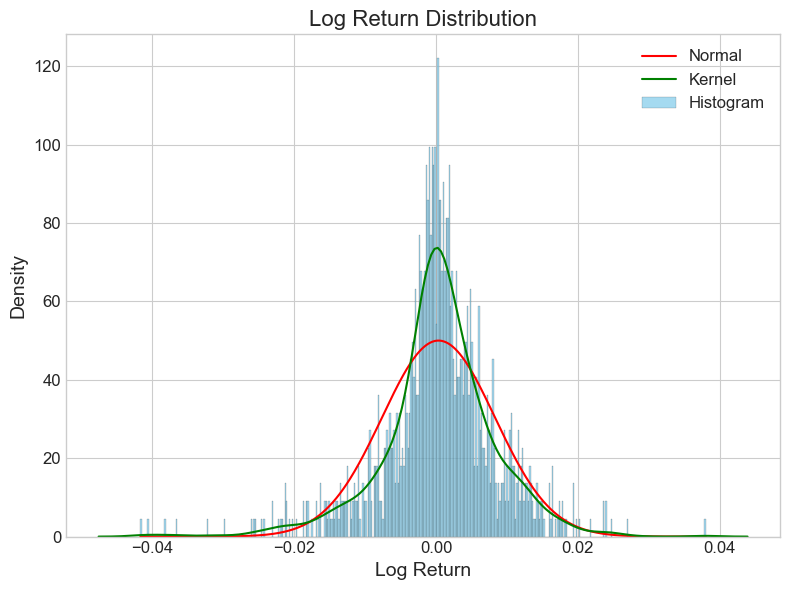

In [18]:
# Prepare data
log_ret = df['return'].dropna()

# Plot
plt.figure(figsize=(8, 6))
sns.histplot(log_ret, kde=False, stat='density', bins=400, color='skyblue', label='Histogram')

# Normal fit
mu, std = norm.fit(log_ret)
x_vals = np.linspace(log_ret.min(), log_ret.max(), 500)
plt.plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Kernel Density Estimate
sns.kdeplot(log_ret, color='green', label='Kernel')

# Labels and formatting
plt.title('Log Return Distribution', fontsize=16)
plt.xlabel('Log Return', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Distribution of RV

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

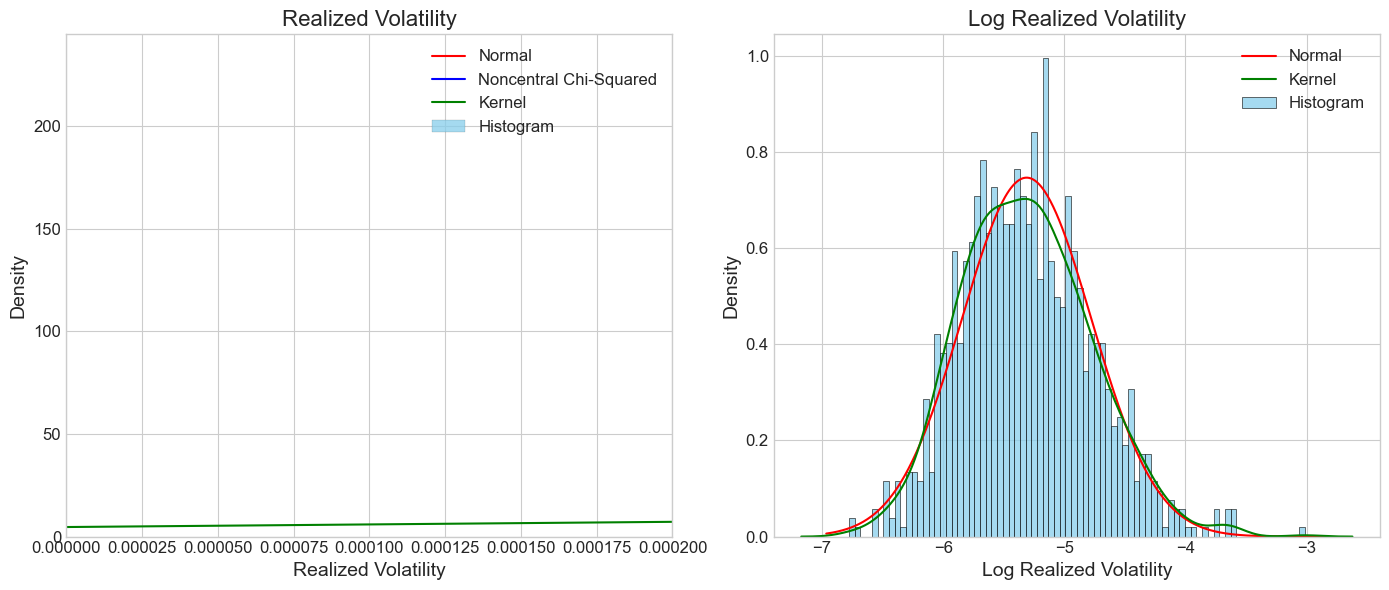

In [19]:
# Prepare data
rv = np.sqrt(df['rv10']).dropna()
log_rv = np.log(rv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Realized volatility histogram and density curves
sns.histplot(rv, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rv.min(), rv.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the log normal distribution
# shape_logn, loc_logn, scale_logn = lognorm.fit(rv, floc=0)  # Usually loc is set to 0
# ax[0].plot(x_vals, lognorm.pdf(x_vals, shape_logn, loc=loc_logn, scale=scale_logn), 'r', label='Lognormal')

mu, std = norm.fit(rv)
ax[0].plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Fit the noncentral chi-squared distribution with loc fixed at 0
df_ncx2, nc_val, loc_val, scale_val = ncx2.fit(rv, floc=0)
ax[0].plot(x_vals, ncx2.pdf(x_vals, df_ncx2, nc_val, loc=loc_val, scale=scale_val), 'b', label='Noncentral Chi-Squared')

# Add kernel density estimate
sns.kdeplot(rv, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Realized Volatility', fontsize=16)
ax[0].set_xlabel('Realized Volatility', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].set_xlim(0, 0.0002)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log realized volatility histogram and normal density
sns.histplot(log_rv, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rv)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rv, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log Realized Volatility', fontsize=16)
ax[1].set_xlabel('Log Realized Volatility', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


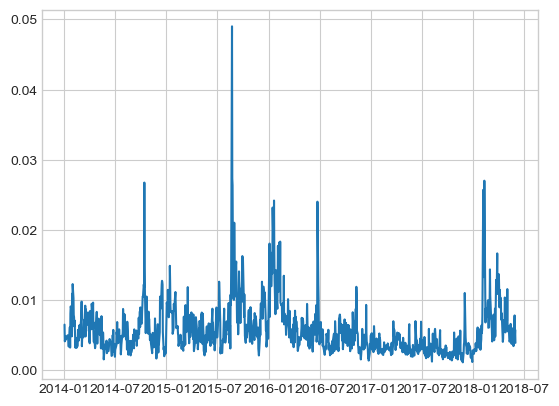

In [20]:
plt.plot(rv)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

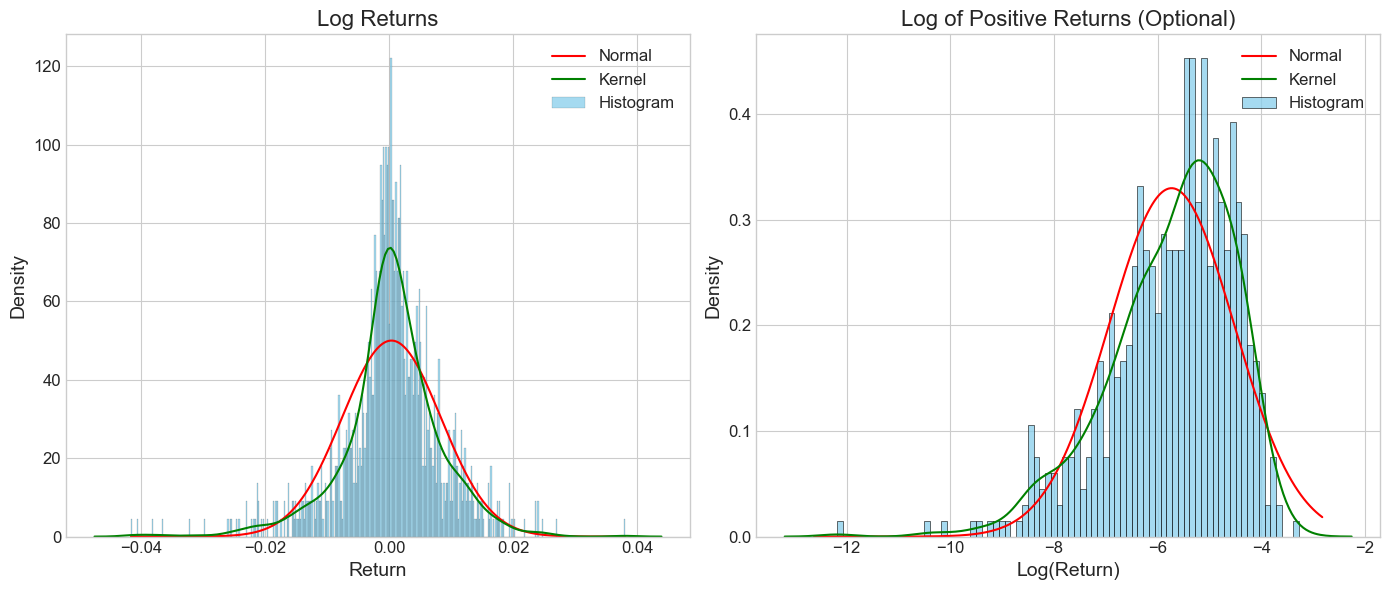

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Prepare data
rtn = np.log(df['close_price']).diff().dropna()
log_rtn = np.log(rtn[rtn > 0])  # optional, if you want to still look at log of positive returns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Return histogram and density curves
sns.histplot(rtn, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rtn.min(), rtn.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the normal distribution
mu_rtn, std_rtn = norm.fit(rtn)
ax[0].plot(x_vals, norm.pdf(x_vals, mu_rtn, std_rtn), 'r', label='Normal')

# Add kernel density estimate
sns.kdeplot(rtn, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Log Returns', fontsize=16)
ax[0].set_xlabel('Return', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log of positive returns (optional, for exploration)
sns.histplot(log_rtn, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rtn)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rtn, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log of Positive Returns (Optional)', fontsize=16)
ax[1].set_xlabel('Log(Return)', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


# Autocorrelation

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


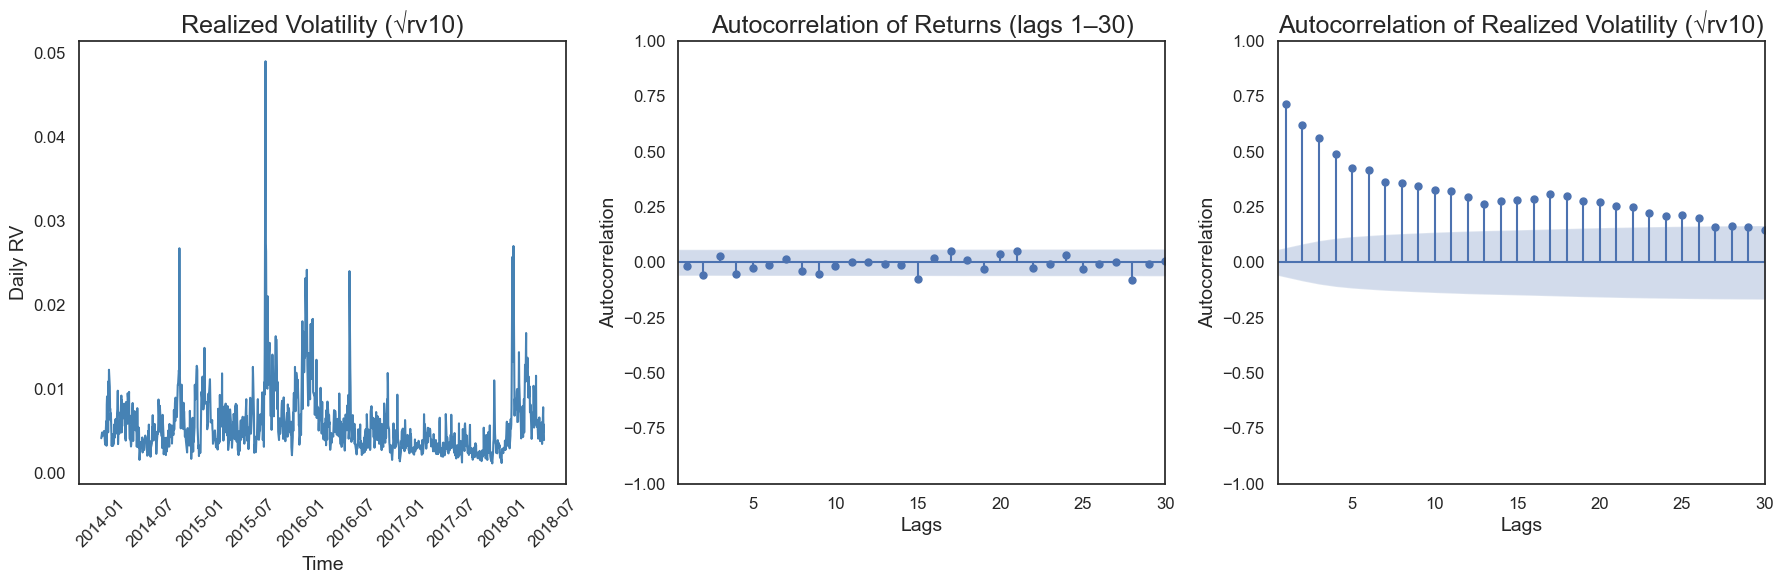

In [22]:
returns = np.log(df['close_price']).diff().iloc[1:]
rv10 = df['rv10'].iloc[1:]
realized_vol = np.sqrt(rv10)

sns.set(style='white')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volatility plot 
sns.lineplot(x=realized_vol.index, y=realized_vol.values, ax=axes[0], color='steelblue')
axes[0].set_title('Realized Volatility (√rv10)', fontsize=18)
axes[0].set_xlabel('Time', fontsize=14)
axes[0].set_ylabel('Daily RV', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# 2. Autocorrelation of returns
plot_acf(returns, lags=30, ax=axes[1])
axes[1].set_title('Autocorrelation of Returns (lags 1–30)', fontsize=18)
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Autocorrelation', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0.5, 30)

# 3. Autocorrelation of realized volatility
plot_acf(realized_vol, lags=30, ax=axes[2])
axes[2].set_title('Autocorrelation of Realized Volatility (√rv10)', fontsize=18)
axes[2].set_xlabel('Lags', fontsize=14)
axes[2].set_ylabel('Autocorrelation', fontsize=14)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].set_xlim(0.5, 30)

plt.tight_layout()
plt.show()